In [38]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

<a href="https://colab.research.google.com/github/lmoroney/dlaicourse/blob/master/TensorFlow%20In%20Practice/Course%203%20-%20NLP/Course%203%20-%20Week%202%20-%20Lesson%202.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Run this to ensure TensorFlow 2.x is used
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


In [26]:
import json
import tensorflow as tf

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import plot_model

In [3]:
vocab_size = 10000
embedding_dim = 16
max_length = 100
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"
training_size = 20000


In [4]:
!wget --no-check-certificate \
    https://storage.googleapis.com/learning-datasets/sarcasm.json \
    -O /tmp/sarcasm.json


--2025-02-15 19:47:57--  https://storage.googleapis.com/learning-datasets/sarcasm.json
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.10.207, 142.251.12.207, 172.217.194.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.10.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5643545 (5.4M) [application/json]
Saving to: ‘/tmp/sarcasm.json’

/tmp/sarcasm.json   100%[===================>]   5.38M  3.90MB/s    in 1.4s    

2025-02-15 19:48:00 (3.90 MB/s) - ‘/tmp/sarcasm.json’ saved [5643545/5643545]



In [12]:
with open("/tmp/sarcasm.json", 'r') as f:
    datastore = json.load(f)

sentences = []
labels = []
urls = []

for item in datastore:
    sentences.append(item['headline'])
    labels.append(item['is_sarcastic'])
    urls.append(item['article_link'])

In [15]:
len(sentences)

26709

In [16]:
training_sentences = sentences[0:training_size]
testing_sentences = sentences[training_size:]
training_labels = labels[0:training_size]
testing_labels = labels[training_size:]

In [18]:
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(training_sentences)

word_index = tokenizer.word_index

training_sequences = tokenizer.texts_to_sequences(training_sentences)
training_padded = pad_sequences(training_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

In [20]:
# Need this block to get it to work with TensorFlow 2.x
import numpy as np
training_padded = np.array(training_padded)
training_labels = np.array(training_labels)
testing_padded = np.array(testing_padded)
testing_labels = np.array(testing_labels)

In [21]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


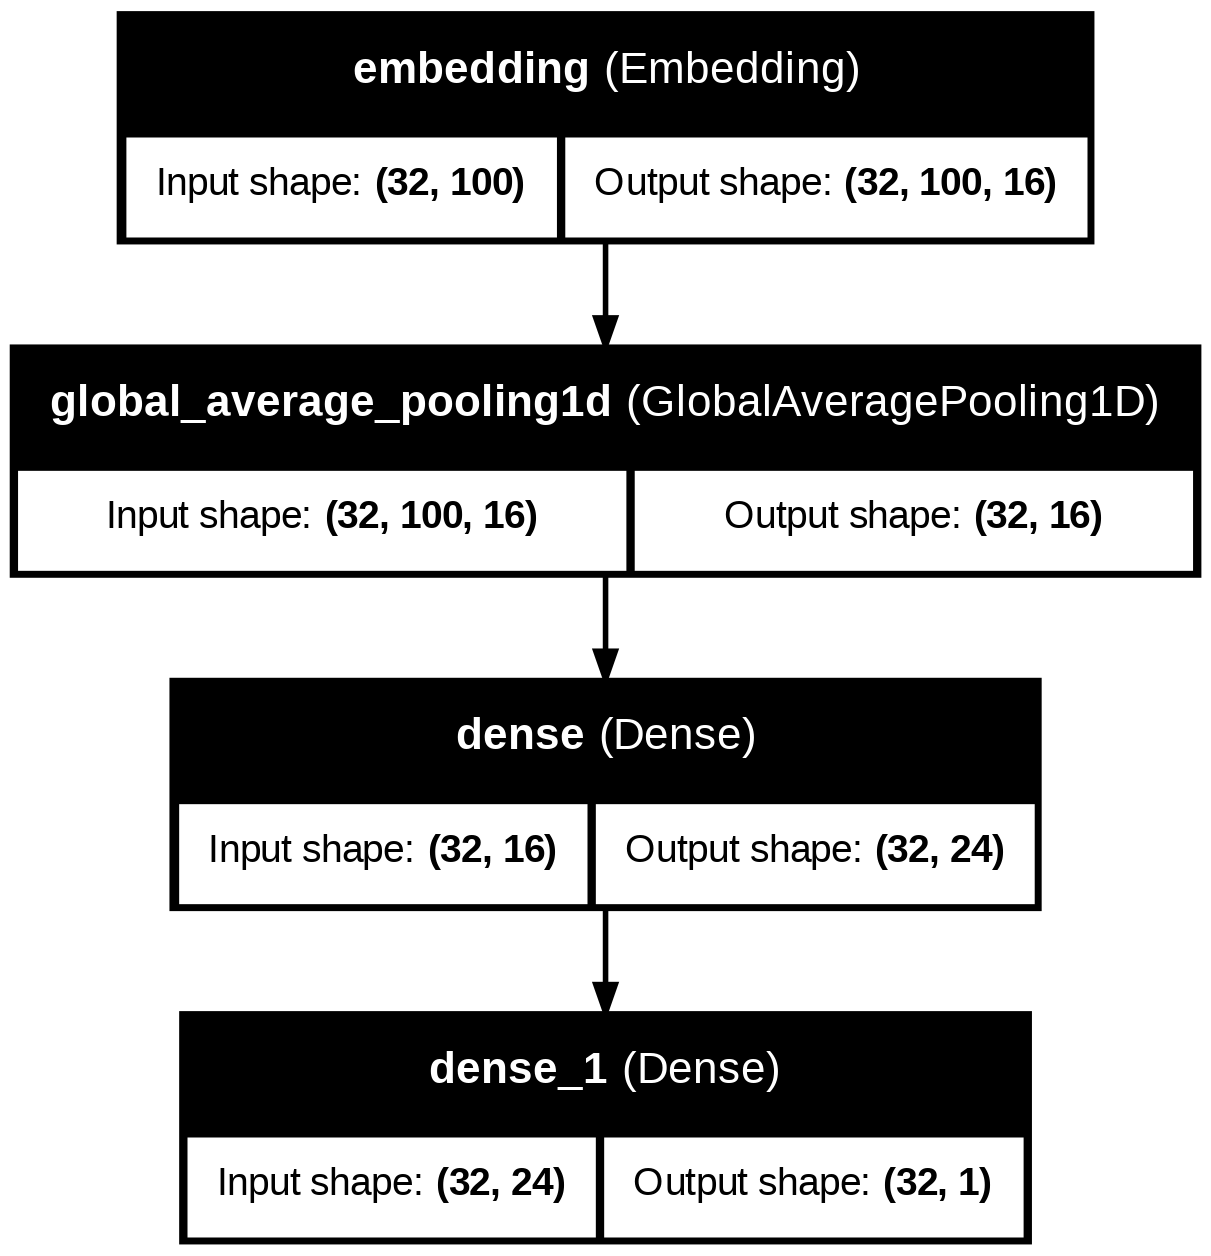

In [27]:
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [24]:
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (32, 100, 16)               │         160,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d             │ (32, 16)                    │               0 │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (32, 24)                    │             408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (32, 1)                     │              25 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 481,301 (1.84 MB)

 Trainable params: 160,433 (626.69 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 320,868 (1.22 MB)

In [23]:
num_epochs = 30
history = model.fit(training_padded, training_labels, epochs=num_epochs, validation_data=(testing_padded, testing_labels), verbose=2)

Epoch 1/30
625/625 - 6s - 9ms/step - accuracy: 0.5612 - loss: 0.6811 - val_accuracy: 0.5633 - val_loss: 0.6592
Epoch 2/30
625/625 - 2s - 3ms/step - accuracy: 0.7257 - loss: 0.5476 - val_accuracy: 0.7776 - val_loss: 0.4733
Epoch 3/30
625/625 - 2s - 3ms/step - accuracy: 0.8256 - loss: 0.4067 - val_accuracy: 0.7573 - val_loss: 0.4774
Epoch 4/30
625/625 - 3s - 4ms/step - accuracy: 0.8558 - loss: 0.3468 - val_accuracy: 0.8444 - val_loss: 0.3725
Epoch 5/30
625/625 - 3s - 4ms/step - accuracy: 0.8681 - loss: 0.3176 - val_accuracy: 0.8240 - val_loss: 0.3833
Epoch 6/30
625/625 - 3s - 5ms/step - accuracy: 0.8842 - loss: 0.2838 - val_accuracy: 0.8545 - val_loss: 0.3492
Epoch 7/30
625/625 - 2s - 4ms/step - accuracy: 0.8852 - loss: 0.2725 - val_accuracy: 0.8314 - val_loss: 0.3723
Epoch 8/30
625/625 - 2s - 3ms/step - accuracy: 0.8981 - loss: 0.2509 - val_accuracy: 0.8350 - val_loss: 0.3691
Epoch 9/30
625/625 - 2s - 4ms/step - accuracy: 0.9083 - loss: 0.2289 - val_accuracy: 0.8141 - val_loss: 0.4340
E

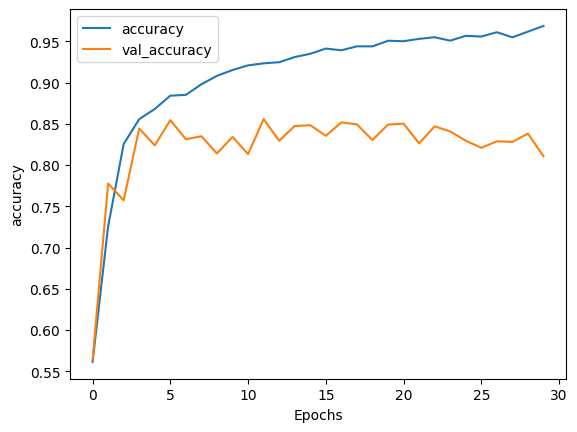

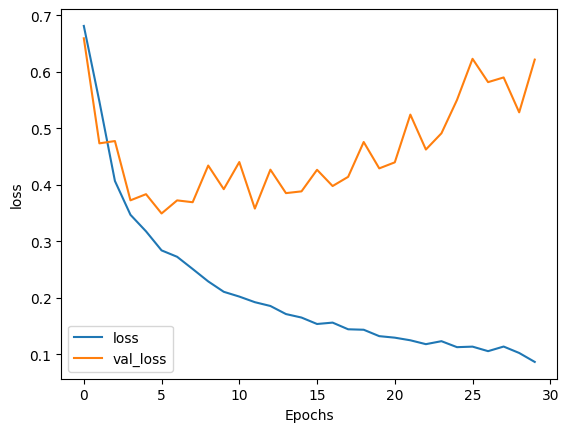

In [28]:
import matplotlib.pyplot as plt


def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [29]:
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

def decode_sentence(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])

print(decode_sentence(training_padded[0]))
print(training_sentences[2])
print(labels[2])

former <OOV> store clerk sues over secret 'black <OOV> for minority shoppers ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ?
mom starting to fear son's web series closest thing she will have to grandchild
1


In [30]:
e = model.layers[0]
weights = e.get_weights()[0]
print(weights.shape) # shape: (vocab_size, embedding_dim)


(10000, 16)


In [31]:
import io

out_v = io.open('vecs.tsv', 'w', encoding='utf-8')
out_m = io.open('meta.tsv', 'w', encoding='utf-8')
for word_num in range(1, vocab_size):
  word = reverse_word_index[word_num]
  embeddings = weights[word_num]
  out_m.write(word + "\n")
  out_v.write('\t'.join([str(x) for x in embeddings]) + "\n")
out_v.close()
out_m.close()

In [32]:
try:
  from google.colab import files
except ImportError:
  pass
else:
  files.download('vecs.tsv')
  files.download('meta.tsv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [33]:
sentence = ["granny starting to fear spiders in the garden might be real", "game of thrones season finale showing this sunday night"]
sequences = tokenizer.texts_to_sequences(sentence)
padded = pad_sequences(sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)
print(model.predict(padded))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 360ms/step
[[0.9720929 ]
 [0.15801047]]
